# Test Symmetry and Monotonicity Operators

These will eventually become tests in meas_deblender, but for now we use them just to ensure that our operators are working properly

In [1]:
from __future__ import print_function, division
import os
from collections import OrderedDict
import logging

import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# Make the plots look pretty
matplotlib.rc('font',size=13)
matplotlib.rc('legend', numpoints=1)
matplotlib.rc('image', cmap='inferno')
matplotlib.rc('image', interpolation='none')
# Use the same color cylcer as Seaborn
from cycler import cycler
color_cycle = [u'#4c72b0', u'#55a868', u'#c44e52', u'#8172b2', u'#ccb974', u'#64b5cd']
matplotlib.rcParams['axes.prop_cycle'] = cycler("color", color_cycle)

import lsst.afw.table as afwTable
import lsst.log as log
import lsst.meas.deblender
from lsst.meas.deblender import nmf
import lsst.meas.deblender.utils as debUtils

logger = logging.getLogger("lsst.meas.deblender")
logger.setLevel(logging.INFO)
log.setLevel("", log.INFO)

# Numerically show that the symmetry operator is working as expected

This cell tests the symmetry operator on rectangular (non-square) matrices with the peak in different quadrants, verifying that the symmetry operator is working correctly on all of them

In [2]:
# This is just a visual sanity check
# The cells that follow are a more numerical check
def testSym(xslice, yslice, px, py, shape=(4,5)):
    x = np.ones(shape)
    x[yslice,xslice] = [[1,2,3],[5,6,7],[9,10,11]]
    symmetryOp = nmf.getPeakSymmetryOperator(x.flatten(), shape, px, py)
    print('template\n', x)
    result = symmetryOp.dot(x.flatten()).reshape(x.shape)
    print('symmetric template\n', result)
    return result

result = testSym(slice(None,3),slice(None,3),1,1)
testSym(slice(-3,None),slice(-3, None),3,2)
testSym(slice(None,3),slice(-3,None),1,2)
testSym(slice(-3,None),slice(None,3),3,1)
testSym(slice(None,3),slice(None,3),2,2, shape=(5,5))

template
 [[  1.   2.   3.   1.   1.]
 [  5.   6.   7.   1.   1.]
 [  9.  10.  11.   1.   1.]
 [  1.   1.   1.   1.   1.]]
symmetric template
 [[ 11.  10.   9.   0.   0.]
 [  7.   6.   5.   0.   0.]
 [  3.   2.   1.   0.   0.]
 [  0.   0.   0.   0.   0.]]
template
 [[  1.   1.   1.   1.   1.]
 [  1.   1.   1.   2.   3.]
 [  1.   1.   5.   6.   7.]
 [  1.   1.   9.  10.  11.]]
symmetric template
 [[  0.   0.   0.   0.   0.]
 [  0.   0.  11.  10.   9.]
 [  0.   0.   7.   6.   5.]
 [  0.   0.   3.   2.   1.]]
template
 [[  1.   1.   1.   1.   1.]
 [  1.   2.   3.   1.   1.]
 [  5.   6.   7.   1.   1.]
 [  9.  10.  11.   1.   1.]]
symmetric template
 [[  0.   0.   0.   0.   0.]
 [ 11.  10.   9.   0.   0.]
 [  7.   6.   5.   0.   0.]
 [  3.   2.   1.   0.   0.]]
template
 [[  1.   1.   1.   2.   3.]
 [  1.   1.   5.   6.   7.]
 [  1.   1.   9.  10.  11.]
 [  1.   1.   1.   1.   1.]]
symmetric template
 [[  0.   0.  11.  10.   9.]
 [  0.   0.   7.   6.   5.]
 [  0.   0.   3.   2.   1.]
 [  0

array([[  1.,   1.,   1.,   1.,   1.],
       [  1.,   1.,   1.,   1.,   1.],
       [  1.,   1.,  11.,  10.,   9.],
       [  1.,   1.,   7.,   6.,   5.],
       [  1.,   1.,   3.,   2.,   1.]])

# Test the symmetry operator on a 2D Gaussian matrix

Place the peak in each quadrant and ensure that the symmetry difference operator, the difference between the original and symmetric image, is ~zero.

In [3]:
def gaussian2D(x, y, x0=0, y0=0, A=1, sigma=0.25):
    return A*np.exp(-0.5*((x-x0)**2+(y-y0)**2)/sigma)

def testSym(symmetricPatch, xslice, yslice, px, py, shape, zeros=True):
    # Offset the symmetric patch depending on the shape of the image and position of the peak
    width = symmetricPatch.shape[0]
    if zeros:
        img = np.zeros(shape)
    else:
        img = 0.5*np.ones(shape)
    img[yslice, xslice] = symmetricPatch
    plt.imshow(img)
    plt.title("Original")
    plt.axis('off')
    plt.show()
    # Create a symmetry operator for the image
    symOp = nmf.getPeakSymmetryOperator(img.flatten(), img.shape, px, py)
    imgSym = symOp.dot(img.flatten()).reshape(img.shape)
    plt.imshow(imgSym)
    plt.title("Symmetric")
    plt.axis('off')
    plt.show()
    # Create the symmetry difference operator: (1-symmetryOp)
    diffOp = nmf.getPeakSymmetryDiffOperator(img.flatten(), img.shape, px, py)
    diff = diffOp.dot(img.flatten())
    logger.info("Max difference: {0}".format(np.max(diff)))
    return np.max(diff), img, imgSym, diff

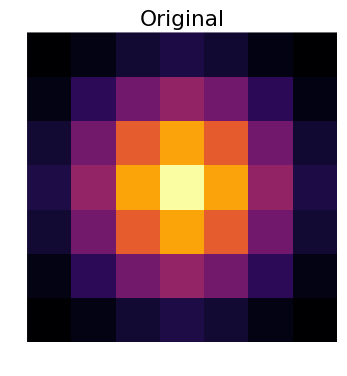

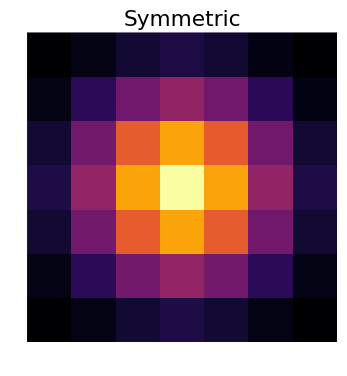

INFO:lsst.meas.deblender:Max difference: 2.77555756156e-16


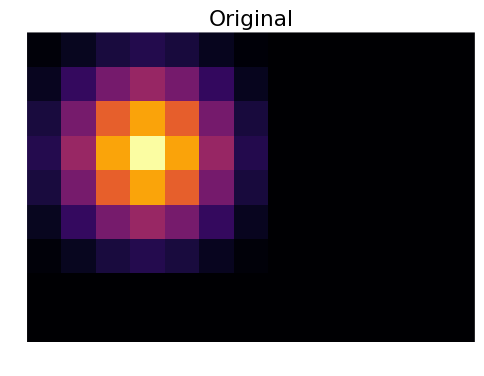

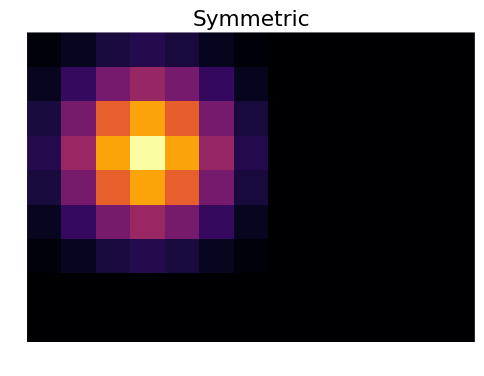

INFO:lsst.meas.deblender:Max difference: 2.77555756156e-16


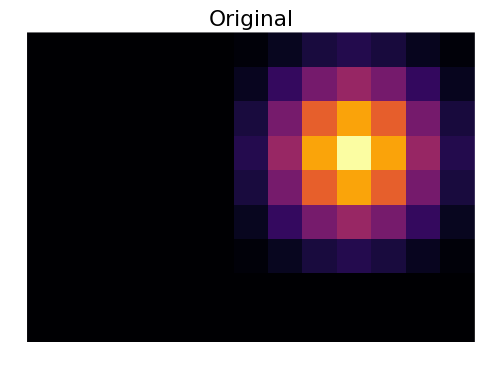

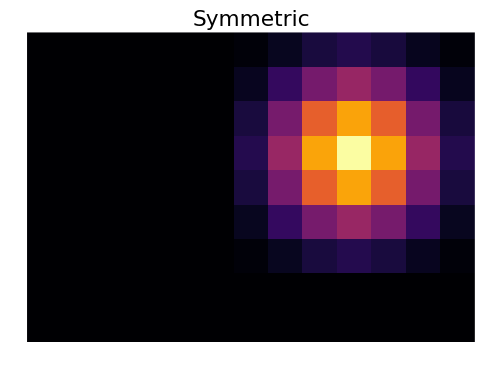

INFO:lsst.meas.deblender:Max difference: 2.77555756156e-16


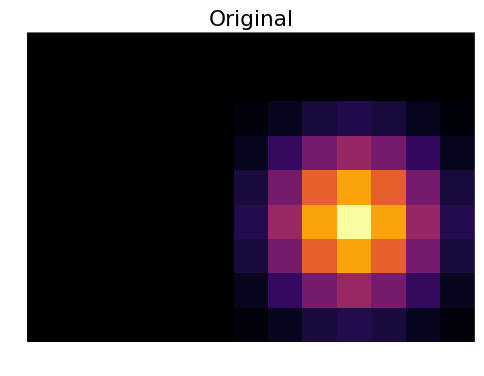

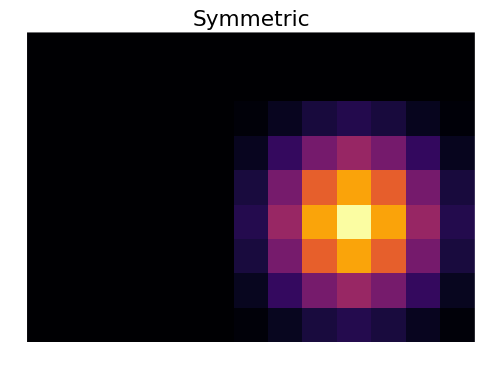

INFO:lsst.meas.deblender:Max difference: 2.77555756156e-16


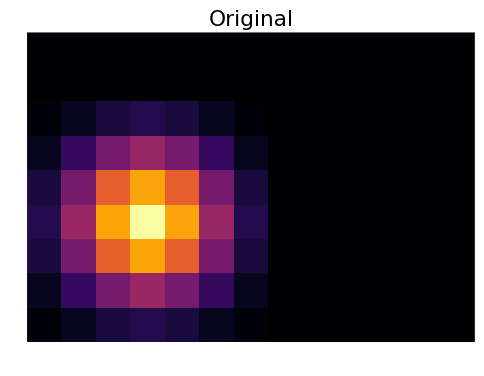

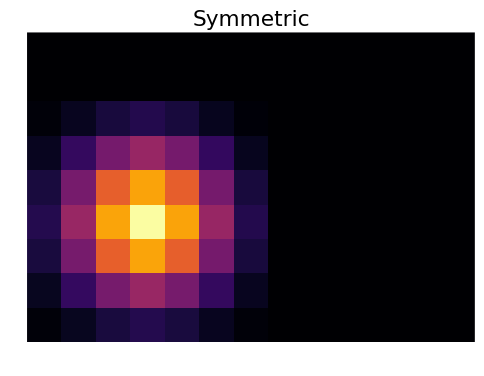

INFO:lsst.meas.deblender:Max difference: 2.77555756156e-16


In [4]:
# Create the Gaussian to use for the test
x = np.linspace(-1,1,7)
y = np.linspace(-1,1,7)
X,Y = np.meshgrid(x,y)
patch = gaussian2D(X, Y)
width = x.shape[0]
center = int(0.5*(width-1))
shape = (width+2, width+6)
cx, cy = (center, center)

testSym(patch, slice(None, None), slice(None, None), cx, cy, (width, width));
testSym(patch, slice(None, width), slice(None, width), cx, cy, shape);
testSym(patch, slice(-width, None), slice(None, width), shape[1]-cx-1, cy, shape);
testSym(patch, slice(-width, None), slice(-width, None), shape[1]-cx-1, shape[0]-cy-1, shape);
testSym(patch, slice(None, width), slice(-width, None), cx, shape[0]-cy-1, shape);

# Test non-symmetric

Next run the same test with a non-zero background, which will cause the original and symmetric images to have a difference of 0.5

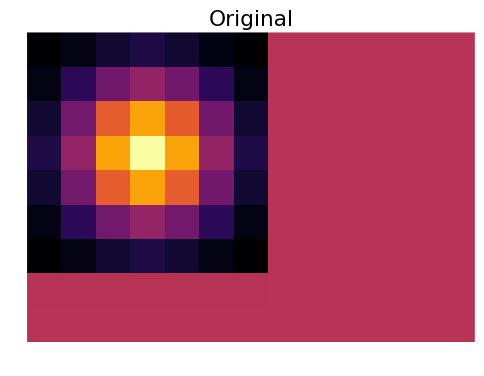

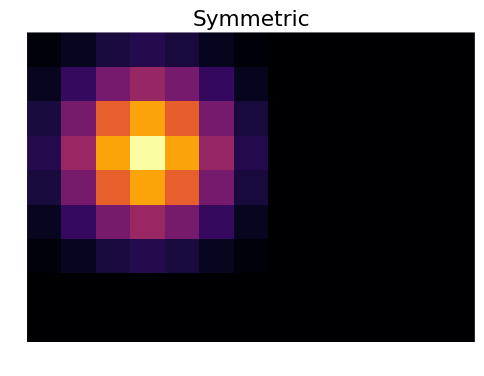

INFO:lsst.meas.deblender:Max difference: 0.5


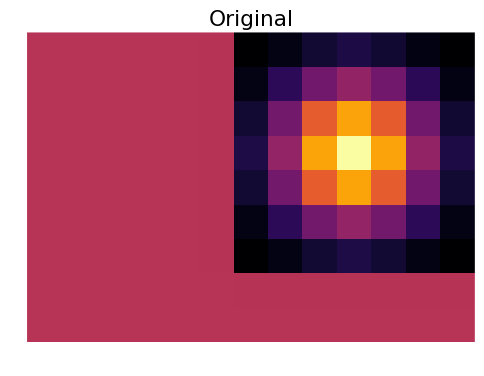

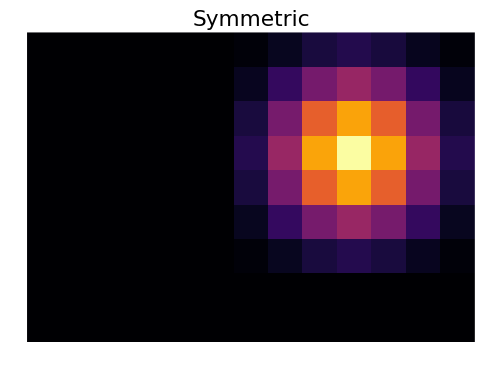

INFO:lsst.meas.deblender:Max difference: 0.5


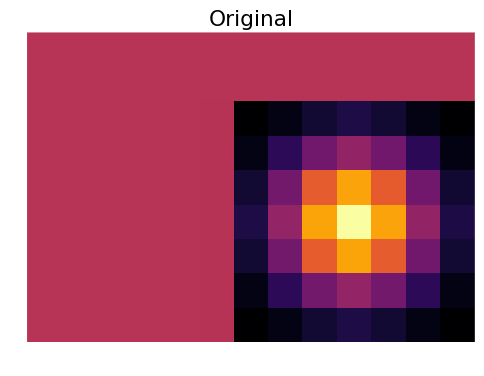

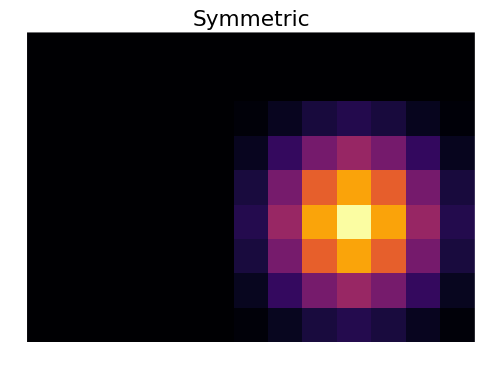

INFO:lsst.meas.deblender:Max difference: 0.5


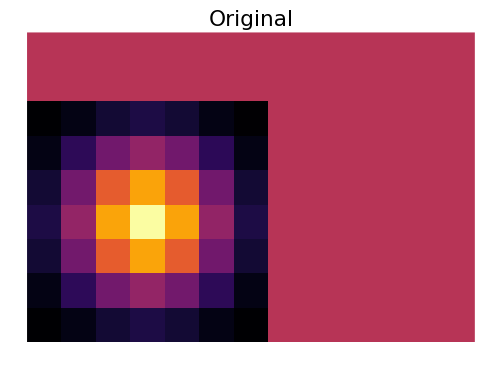

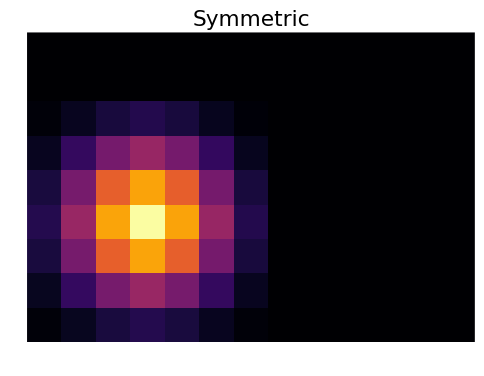

INFO:lsst.meas.deblender:Max difference: 0.5


In [5]:
testSym(patch, slice(None, width), slice(None, width), cx, cy, shape, zeros=False);
testSym(patch, slice(-width, None), slice(None, width), shape[1]-cx-1, cy, shape, zeros=False);
testSym(patch, slice(-width, None), slice(-width, None), shape[1]-cx-1, shape[0]-cy-1, shape, zeros=False);
testSym(patch, slice(None, width), slice(-width, None), cx, shape[0]-cy-1, shape, zeros=False);

# Display sample monotonicty matrices

The X and Y monotonicity matrices are slightly different, as seen below

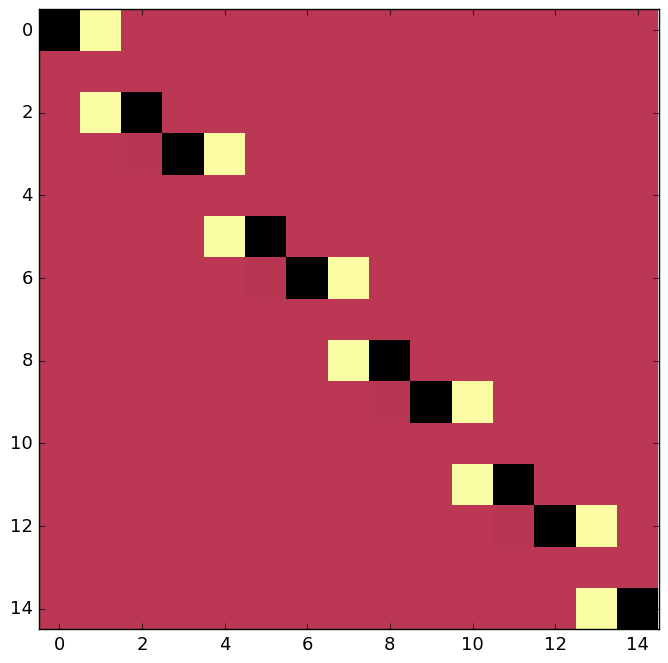

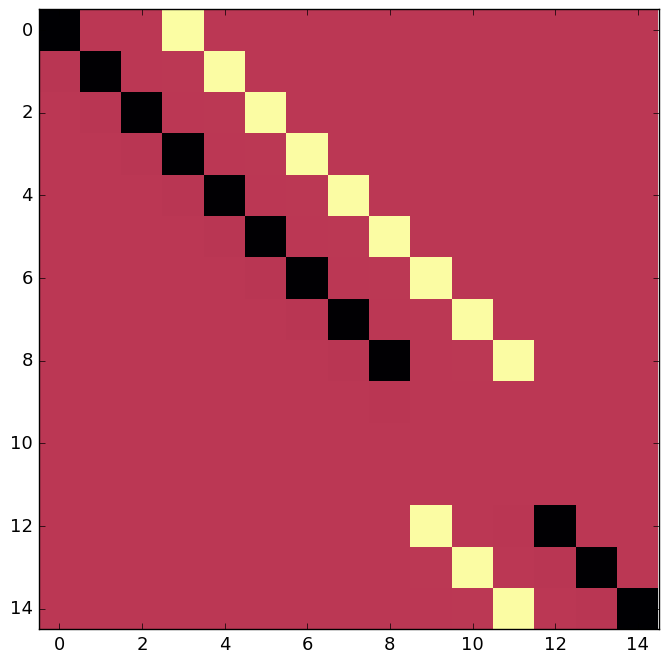

In [6]:
plt.figure(figsize=(8,8))
plt.imshow(nmf.getMonotonicOpX((5,3), 1).toarray())
plt.show()
plt.figure(figsize=(8,8))
plt.imshow(nmf.getMonotonicOpY((5,3), 3).toarray())
plt.show()

# Test the monotonicity matrices

This tests monotonicity in both X and Y by creating an image of a pyramid and creating the monotonic operators centered at the apex, so that all of the operators should be monotonic.

In [7]:
def testMonotonic(shape, px, py):
    # Create a pyramid with shape ``shape``, centered on the image
    x = np.linspace(-1,1, shape[1])
    y = np.linspace(-1,1, shape[0])
    cx = shape[1]//2
    cy = shape[0]//2
    X,Y = np.meshgrid(x,y)
    pyramid = np.zeros(shape)
    pyramid[:cy+1, :cx+1] = (X+Y)[:cy+1, :cx+1]
    pyramid[:cy+1, cx+1:] = (Y-X)[:cy+1, cx+1:]
    pyramid[cy+1:, :cx+1] = (X-Y)[cy+1:, :cx+1]
    pyramid[cy+1:, cx+1:] = (-X-Y)[cy+1:, cx+1:]
    pyramid -= np.min(pyramid)
    plt.imshow(pyramid)
    plt.title("Image")
    plt.show()
    
    # Get a monotonic operator centered on peakX, peakY
    mx = nmf.getMonotonicOpX(shape, px)
    # Show the gradient
    xGrad = mx.dot(pyramid.flatten())
    plt.imshow(xGrad.reshape(shape))
    plt.title("X Gradient")
    plt.show()
    # Get the non-monotonic pixels
    badGrad = np.zeros(pyramid.size)
    badGrad[xGrad<0] = 1
    plt.imshow(badGrad.reshape(shape))
    plt.title("Non-Monotonic in X")
    plt.show()
    
    # Get a monotonic operator centered on peakX, peakY
    my = nmf.getMonotonicOpY(shape, py)
    # Show the gradient
    yGrad = my.dot(pyramid.flatten())
    plt.imshow(yGrad.reshape(shape))
    plt.title("Y Gradient")
    plt.show()
    # Get the non-monotonic pixels
    badGrad = np.zeros(pyramid.size)
    badGrad[yGrad<0] = 1
    plt.imshow(badGrad.reshape(shape))
    plt.title("Non-Monotonic in Y")
    plt.show()
    

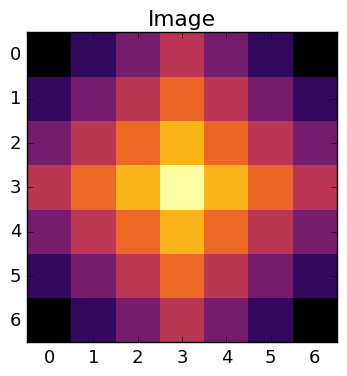

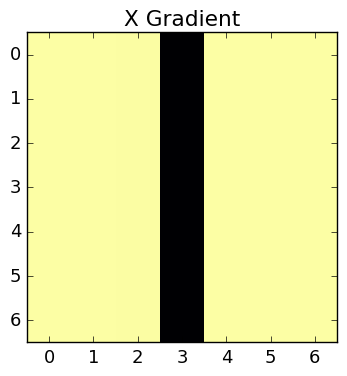

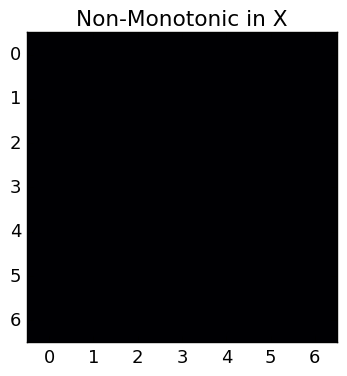

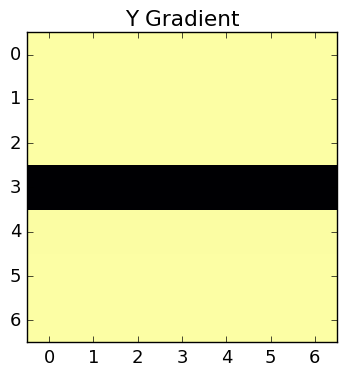

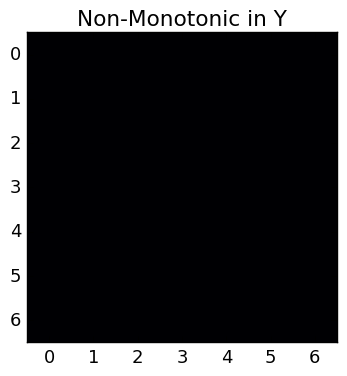

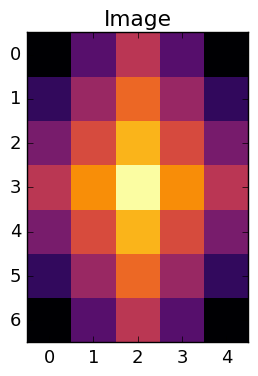

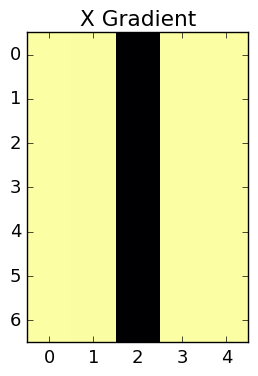

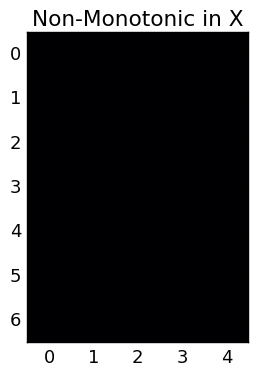

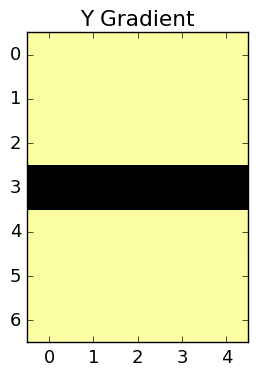

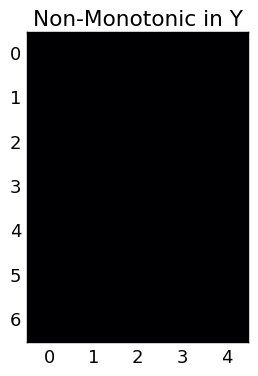

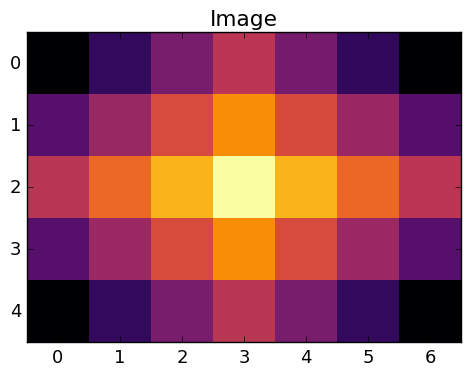

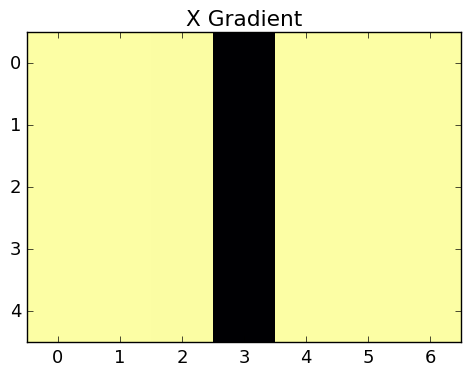

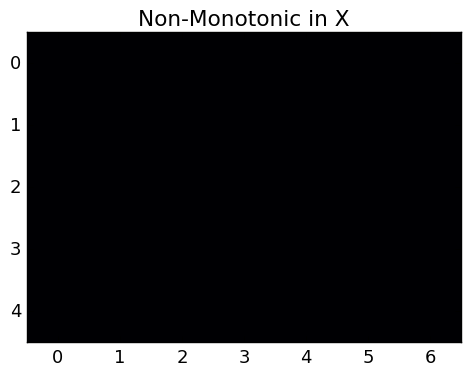

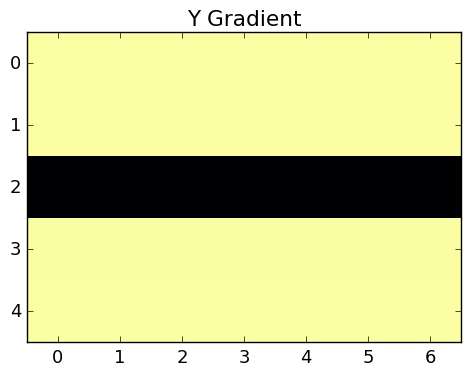

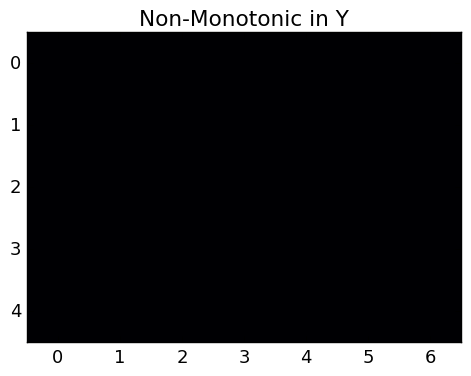

In [8]:
testMonotonic(shape=(7,7), px=3, py=3)
testMonotonic(shape=(7,5), px=2, py=3)
testMonotonic(shape=(5,7), px=3, py=2)

# Test non-monotonic peaks

Now test that the operators work when the peak of the operator is not at the apex of the pyramid.

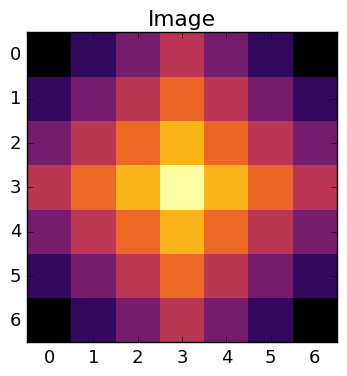

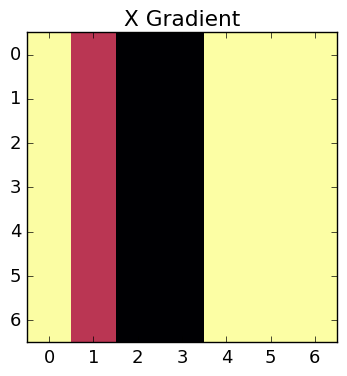

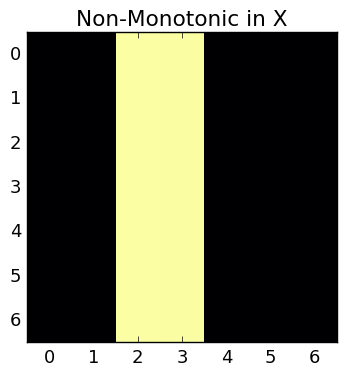

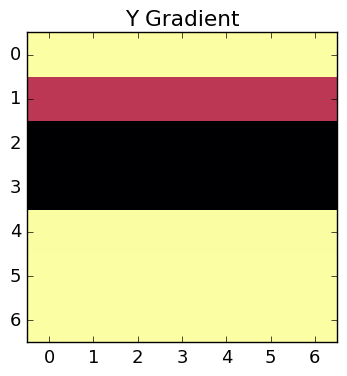

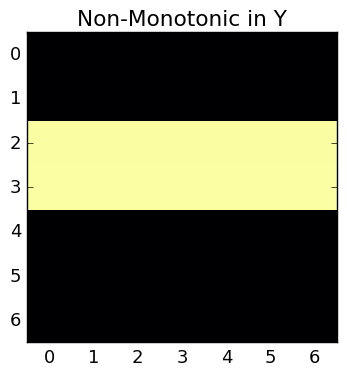

In [9]:
testMonotonic(shape=(7,7), px=1, py=1)

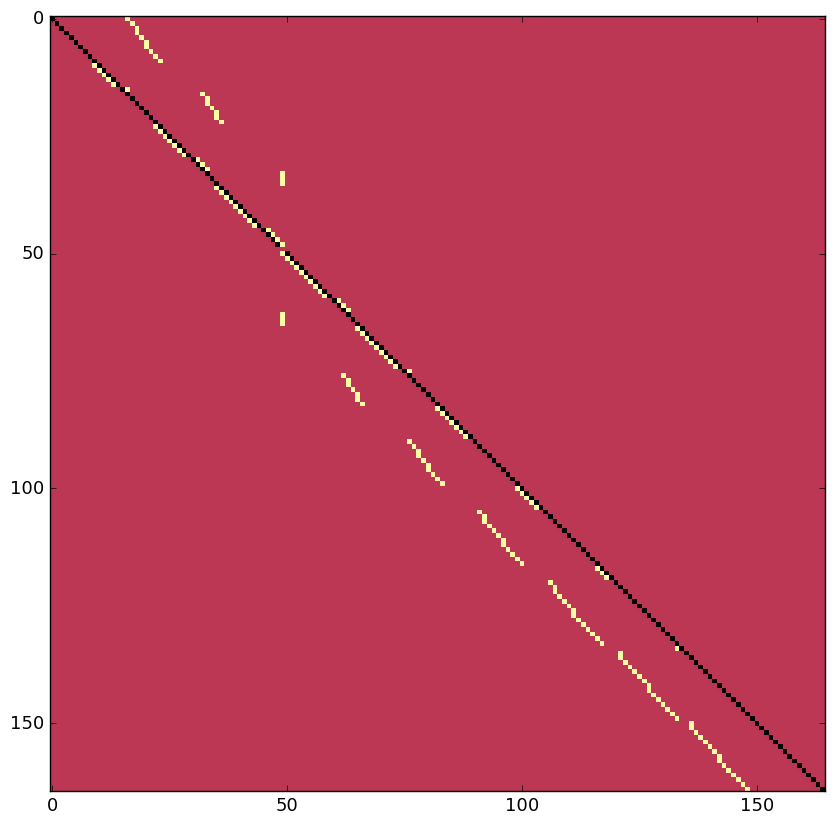

In [2]:
monotonic = nmf.getRadialMonotonicOp((11,15), 4, 3)
plt.figure(figsize=(10,10))
plt.imshow(monotonic.toarray())
plt.show()

In [9]:
height, width = 11, 15
indices = np.arange(height*width)
edges = (np.mod(indices, width)==0) | (indices<width) | (indices>=width*(height-1)) | (np.mod(indices, width)==14)
monotonic.toarray()

array([[-1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0., -1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., -1., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ..., -1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0., -1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0., -1.]])

In [10]:
np.sum(monotonic.toarray(), axis=0)[~edges]

array([ 1.,  0.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
        0.,  1.,  2.,  0.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  8.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  1.,  2.,  0.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  0.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
        0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,
        0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,
        1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.])

In [3]:
np.sum(monotonic.toarray(), axis=1)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [13]:
def testMonotonic(shape, px, py):
    # Create a pyramid with shape ``shape``, centered on the image
    x = np.linspace(-1,1, shape[1])
    y = np.linspace(-1,1, shape[0])
    cx = shape[1]//2
    cy = shape[0]//2
    X,Y = np.meshgrid(x,y)
    pyramid = np.zeros(shape)
    pyramid[:cy+1, :cx+1] = (X+Y)[:cy+1, :cx+1]
    pyramid[:cy+1, cx+1:] = (Y-X)[:cy+1, cx+1:]
    pyramid[cy+1:, :cx+1] = (X-Y)[cy+1:, :cx+1]
    pyramid[cy+1:, cx+1:] = (-X-Y)[cy+1:, cx+1:]
    pyramid -= np.min(pyramid)
    plt.imshow(pyramid)
    plt.title("Image")
    plt.show()
    
    # Get a monotonic operator centered on peakX, peakY
    monotonic = nmf.getRadialMonotonicOp(shape, px, py)
    # Show the gradient
    grad = monotonic.dot(pyramid.flatten())
    plt.imshow(grad.reshape(shape))
    plt.title("Radial Gradient")
    plt.show()
    # Get the non-monotonic pixels
    badGrad = np.zeros(pyramid.size)
    badGrad[grad<0] = 1
    plt.imshow(badGrad.reshape(shape))
    plt.title("Non-Monotonic Pixels")
    plt.show()
    # Test that every pixels is used
    height, width = shape
    logger.info("Pixels not used: {0}".format(np.trace(monotonic.toarray())+height*width-1))
    # Test that each pixel is used as a reference at least once
    indices = np.arange(height*width)
    edges = ((np.mod(indices, width)==0) | 
             (indices<width) | 
             (indices>=width*(height-1)) | 
             (np.mod(indices, width)==width-1))
    references = np.sum(monotonic.toarray(), axis=0)[~edges]
    logger.info("Pixels not used as a reference: {0}".format(np.sum(references<0)))

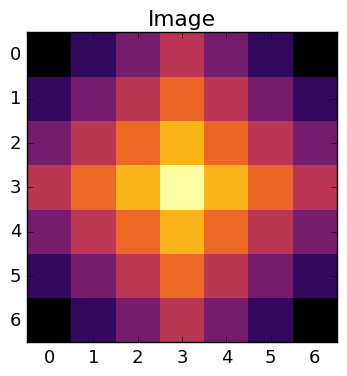

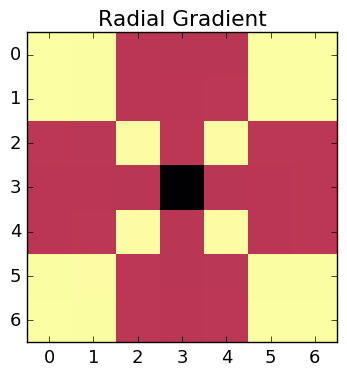

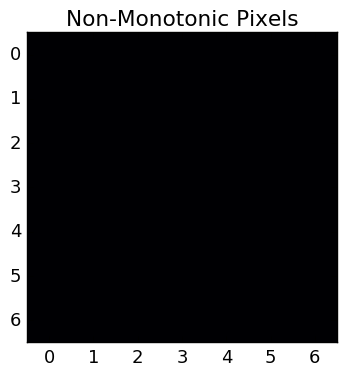

INFO:lsst.meas.deblender:Pixels not used: 0.0
INFO:lsst.meas.deblender:Pixels not used as a reference: 0


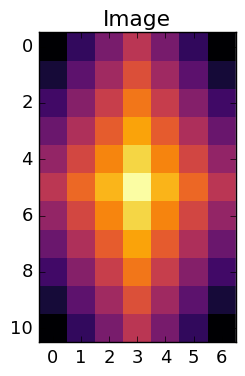

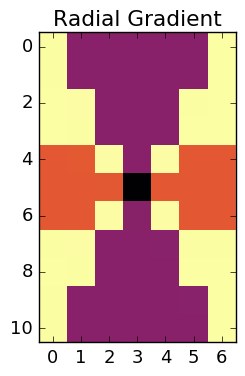

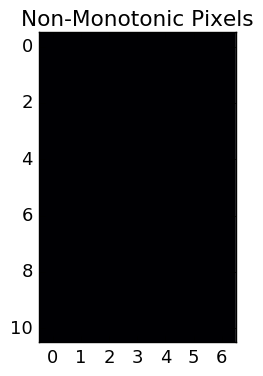

INFO:lsst.meas.deblender:Pixels not used: 0.0
INFO:lsst.meas.deblender:Pixels not used as a reference: 0


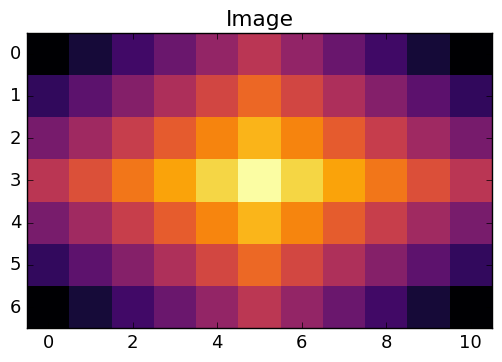

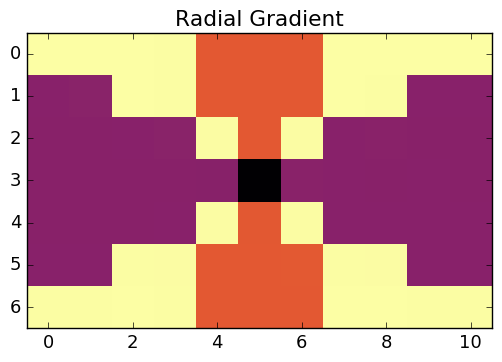

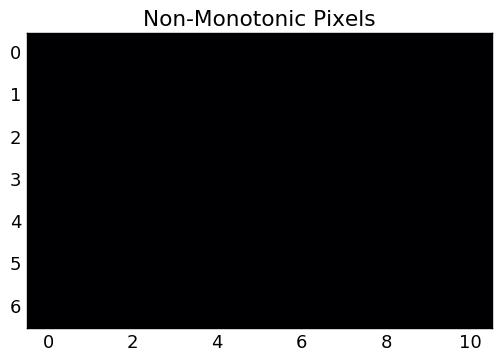

INFO:lsst.meas.deblender:Pixels not used: 0.0
INFO:lsst.meas.deblender:Pixels not used as a reference: 0


In [14]:
testMonotonic(shape=(7,7), px=3, py=3)
testMonotonic(shape=(11,7), px=3, py=5)
testMonotonic(shape=(7,11), px=5, py=3)

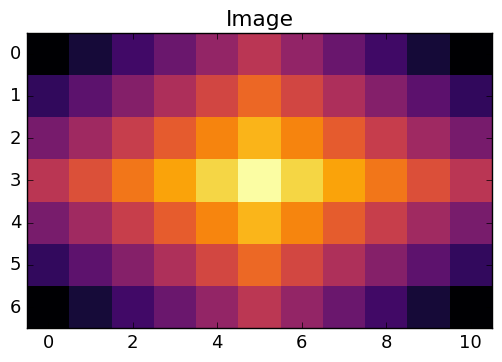

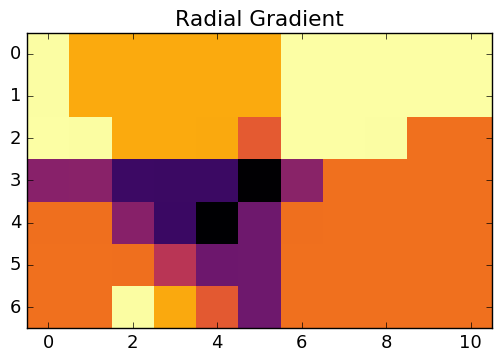

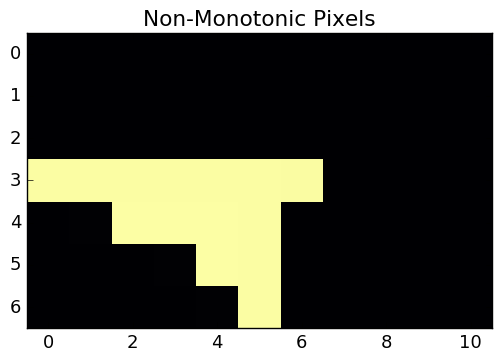

INFO:lsst.meas.deblender:Pixels not used: 0.0
INFO:lsst.meas.deblender:Pixels not used as a reference: 0


In [15]:
testMonotonic(shape=(7,11), px=3, py=5)